**NER**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
raot_cta_ner = pd.read_csv('cta_ner_standard_deviation_msa.csv')

In [3]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date = pd.to_datetime('8/14/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [4]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)

In [5]:
raot_cta_ner['month_year'] = pd.to_datetime(
    raot_cta_ner['WEEK_START']).dt.strftime('%Y-%m')

raot_cta_ner.head()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4,month_year
85716,2014-12-29,568b475d0406580e009c4f1a,568b4796eb46290e00ffb7c1,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,2335.478260,2335.478260,322.0,322.0,2014-12
603680,2014-12-29,568b5dc893fbe30e009f9fad,568b5e519745ea0e00bb9530,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,2312.622166,2312.622166,397.0,397.0,2014-12
862500,2014-12-29,568b4caeeb46290e00ffb7c3,568b4eeb0406580e009c4f67,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,1710.047318,1710.047318,317.0,317.0,2014-12
843534,2014-12-29,568b67e893fbe30e009fa04e,568b68159745ea0e00bb9600,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,1572.194528,1572.194528,329.0,329.0,2014-12
538735,2014-12-29,568b4471eb46290e00ffb787,568b45cfeb46290e00ffb7b3,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,2016.158823,2016.158823,340.0,340.0,2014-12


In [6]:
employment_data = pd.read_csv('employment_data.csv')

employment_data['month_year'] = pd.to_datetime(
    employment_data['Date']).dt.strftime('%Y-%m')

employment_data.head()

,AREA,MSA,Date,VALUE,month_year
0,Abilene,"Abilene, TX",1/1/2011 0:00,65.6,2011-01
1,Abilene,"Abilene, TX",2/1/2011 0:00,65.1,2011-02
2,Abilene,"Abilene, TX",3/1/2011 0:00,65.8,2011-03
3,Abilene,"Abilene, TX",4/1/2011 0:00,65.6,2011-04
4,Abilene,"Abilene, TX",5/1/2011 0:00,65.5,2011-05


In [7]:
new_df = pd.merge(raot_cta_ner, employment_data,  how='inner',
                  left_on=['MSA','month_year'], right_on = ['MSA','month_year'])


new_df.head()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4,month_year,AREA,Date,VALUE
0,2014-12-29,568b475d0406580e009c4f1a,568b4796eb46290e00ffb7c1,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,2335.478260,2335.478260,322.0,322.0,2014-12,Houston-The Woodlands-Sugar Land,12/1/2014 0:00,2994.5
1,2014-12-29,568b5dc893fbe30e009f9fad,568b5e519745ea0e00bb9530,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,2312.622166,2312.622166,397.0,397.0,2014-12,Houston-The Woodlands-Sugar Land,12/1/2014 0:00,2994.5
2,2014-12-29,568b4caeeb46290e00ffb7c3,568b4eeb0406580e009c4f67,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,1710.047318,1710.047318,317.0,317.0,2014-12,Houston-The Woodlands-Sugar Land,12/1/2014 0:00,2994.5
3,2014-12-29,568b67e893fbe30e009fa04e,568b68159745ea0e00bb9600,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,1572.194528,1572.194528,329.0,329.0,2014-12,Houston-The Woodlands-Sugar Land,12/1/2014 0:00,2994.5
4,2014-12-29,568b4471eb46290e00ffb787,568b45cfeb46290e00ffb7b3,2015-01-01,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,2016.158823,2016.158823,340.0,340.0,2014-12,Houston-The Woodlands-Sugar Land,12/1/2014 0:00,2994.5


In [8]:
# Check correlation
new_df.corrwith(new_df["NER_T4"])

NER         0.997481
NER_T4      1.000000
UNITS      -0.077530
UNITS_T4   -0.078588
VALUE       0.316108
dtype: float64

**Simple implementation of fbprohet**

In [9]:
new_df2 = new_df[['WEEK_START', 'MSA', 'NER_T4', 'VALUE']]

In [10]:
new_df2

,WEEK_START,MSA,NER_T4,VALUE
0,2014-12-29,"Houston, TX",2335.478260,2994.5
1,2014-12-29,"Houston, TX",2312.622166,2994.5
2,2014-12-29,"Houston, TX",1710.047318,2994.5
3,2014-12-29,"Houston, TX",1572.194528,2994.5
4,2014-12-29,"Houston, TX",2016.158823,2994.5
...,...,...,...,...
1170937,2022-07-25,"Barnstable Town, MA",1948.724137,100.4
1170938,2022-07-04,"Santa Fe, NM",2272.666666,61.1
1170939,2022-07-11,"Santa Fe, NM",2272.666666,61.1
1170940,2022-07-18,"Santa Fe, NM",2275.546295,61.1


In [11]:
avg_ner_data = new_df2.groupby(['WEEK_START']).agg(
                    {'VALUE':'mean','NER_T4':'mean'}).reset_index()
avg_ner_data

,WEEK_START,VALUE,NER_T4
0,2014-12-29,3023.842857,1677.124299
1,2015-01-05,2668.228814,1453.094374
2,2015-01-12,2659.092188,1436.879588
3,2015-01-19,2659.092188,1437.497635
4,2015-01-26,2611.651515,1416.874571
...,...,...,...
391,2022-06-27,2217.669994,1976.665070
392,2022-07-04,2217.678504,1979.210227
393,2022-07-11,2214.394133,1980.295615
394,2022-07-18,2215.797432,1980.503171


## Prophet Library

In [13]:
from prophet import Prophet
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class prophet_model:
    def __init__(self, algorithm_name, prediction_period):
        self.algorithm_name = algorithm_name
        self.prediction_period = prediction_period
        self.model = Prophet()
        
    def transformation(self, data, time_col, target_col, regressor):
        #data[time_col] = pd.to_datetime(data[time_col])
        data.rename(columns={time_col:'ds', target_col:'y'}, inplace=True)
        
        data.drop(data.columns.difference(['ds','y', regressor]), 1, inplace=True)

        train_data = data[:-self.prediction_period]
        test_data = data[-self.prediction_period:]
        
        return train_data, test_data
    
    def fit_model(self, train_data, regressor):
        self.model.add_regressor(regressor)
        self.model.fit(train_data)
        return self.model
        
    def predict(self, test_data):
        #future_data = self.model.make_future_dataframe(periods=self.prediction_period, freq='w')
        forecast = self.model.predict(df_test)
        predictions = forecast[['ds', 'yhat']]
        #predictions = forecast[['ds', 'yhat']][-self.prediction_period:]
        return predictions
    
    def evaluation(self, test_data, predictions):
        mae = mean_absolute_error(predictions['yhat'], test_data['y'])
        #print("mean_absolute_error on testing set:", mae)
        
        mape = mean_absolute_percentage_error(predictions['yhat'], test_data['y'])
        #print("mean_absolute_percentage_error on testing set:", mape)

        r_squared = r2_score(predictions['yhat'], test_data['y'])
        #print("r2_score on testing set:", r_squared)
        
        return mape
    
    def plot(self, test_data, predictions, label):
        plt.figure(figsize=(10, 5))
        plt.plot(test_data['ds'], test_data['y'], label = 'real data')
        plt.plot(predictions['ds'], predictions['yhat'], label = 'predictions')
        plt.legend()
        plt.title(f'Forecast vs Actuals for {label} with an error of {round(self.evaluation(test_data, predictions),3)}%')
        plt.show()
        
        return None
    
    
    def save_model(self, filename):    
        pickle.dump(self.model, open(filename, 'wb'))

15:43:22 - cmdstanpy - INFO - Chain [1] start processing
15:43:22 - cmdstanpy - INFO - Chain [1] done processing


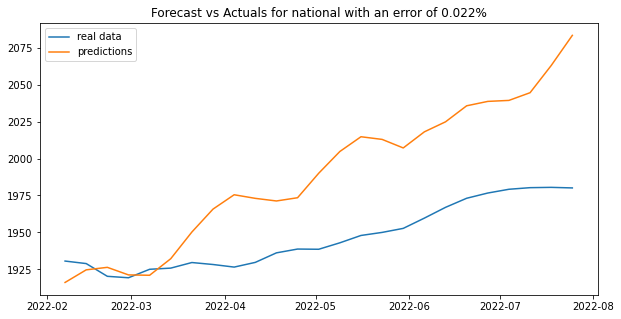

In [15]:
if __name__ == '__main__':
    avg_ner_data = new_df.groupby(['WEEK_START']).agg({'VALUE':'mean','NER_T4':'mean'}).reset_index()

    ## experimenting with a dataset
    prediction_period = 25
    algorithm_name = 'Prophet Model'
    
    results = prophet_model(algorithm_name, prediction_period)
    df_train, df_test = results.transformation(avg_ner_data, 'WEEK_START', 'NER_T4', 'VALUE')
    results.fit_model(df_train, 'VALUE')
    predictions = results.predict(df_test)
    results.evaluation(df_test, predictions)
    results.plot(df_test, predictions, 'national')

# MSA Level

In [16]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in new_df.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby(['WEEK_START']).agg({'VALUE':'mean','NER_T4':'mean'}).reset_index()

15:43:41 - cmdstanpy - INFO - Chain [1] start processing


Atlanta, GA


15:43:41 - cmdstanpy - INFO - Chain [1] done processing


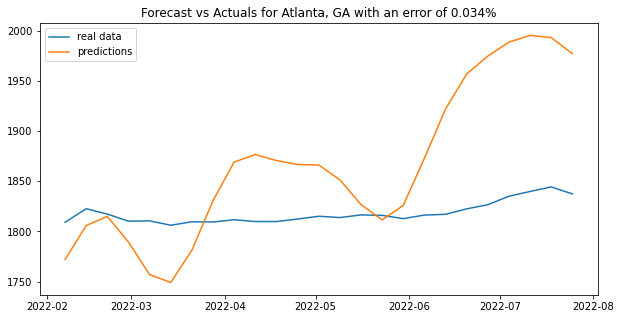

15:43:45 - cmdstanpy - INFO - Chain [1] start processing


Austin, TX


15:43:46 - cmdstanpy - INFO - Chain [1] done processing


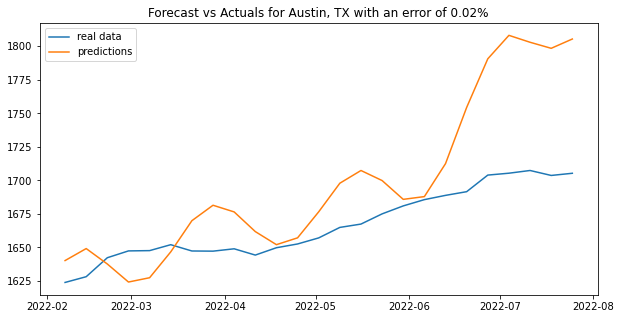

15:43:50 - cmdstanpy - INFO - Chain [1] start processing
15:43:50 - cmdstanpy - INFO - Chain [1] done processing


Baltimore, MD


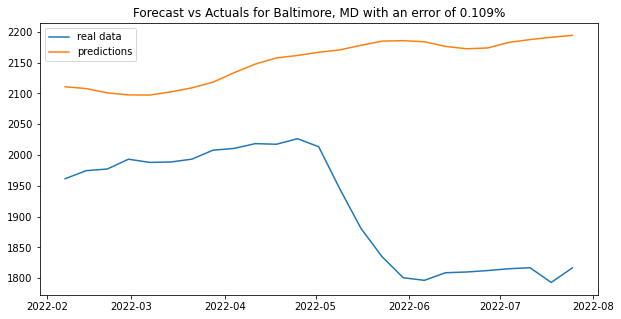

15:43:55 - cmdstanpy - INFO - Chain [1] start processing


Boston, MA


15:43:55 - cmdstanpy - INFO - Chain [1] done processing


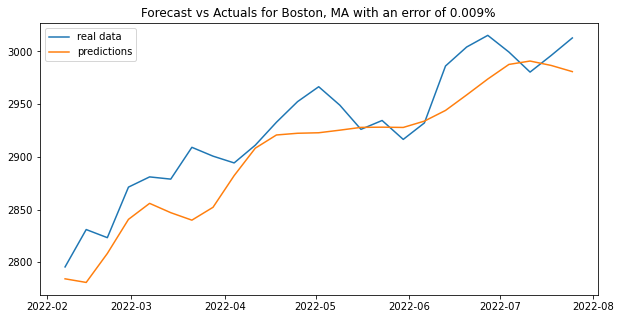

15:43:59 - cmdstanpy - INFO - Chain [1] start processing


Charleston, SC


15:44:00 - cmdstanpy - INFO - Chain [1] done processing


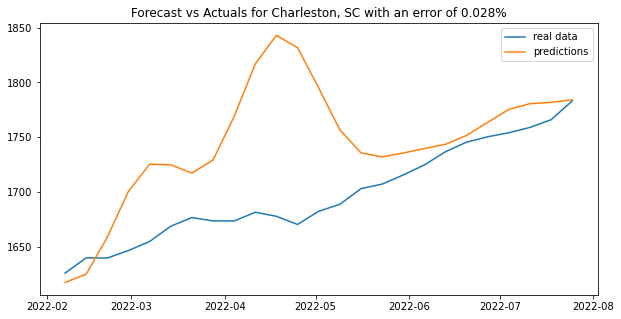

15:44:04 - cmdstanpy - INFO - Chain [1] start processing


Charlotte, NC


15:44:05 - cmdstanpy - INFO - Chain [1] done processing


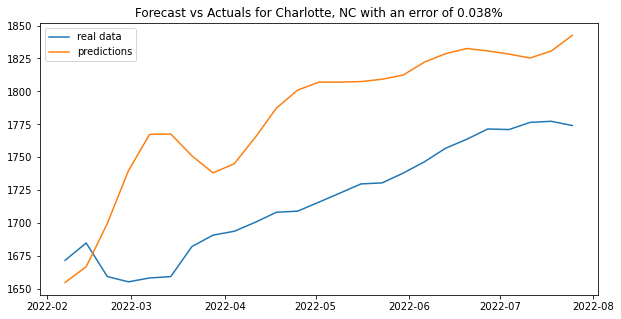

15:44:09 - cmdstanpy - INFO - Chain [1] start processing


Chicago, IL


15:44:09 - cmdstanpy - INFO - Chain [1] done processing


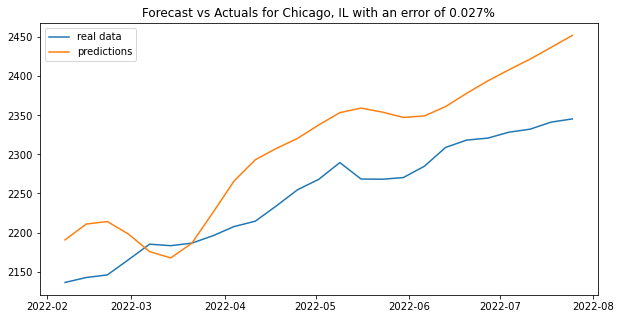

15:44:12 - cmdstanpy - INFO - Chain [1] start processing
15:44:13 - cmdstanpy - INFO - Chain [1] done processing


Dallas, TX


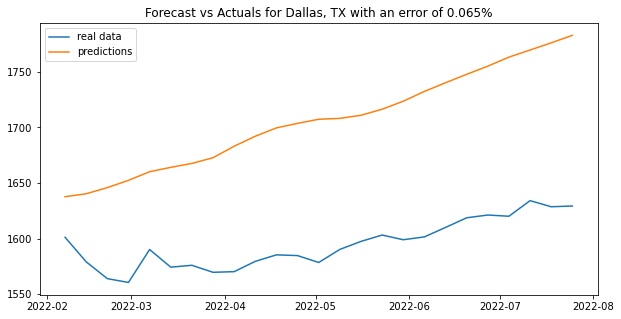

15:44:17 - cmdstanpy - INFO - Chain [1] start processing


Denver, CO


15:44:17 - cmdstanpy - INFO - Chain [1] done processing


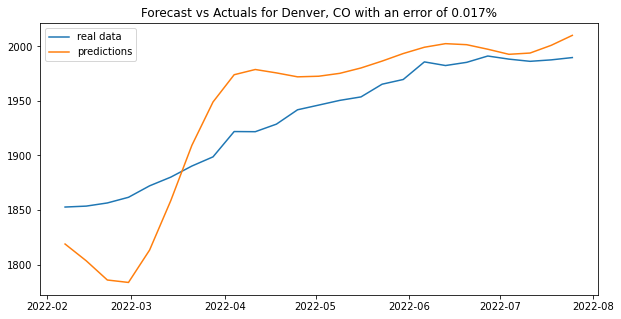

15:44:21 - cmdstanpy - INFO - Chain [1] start processing
15:44:21 - cmdstanpy - INFO - Chain [1] done processing


Houston, TX


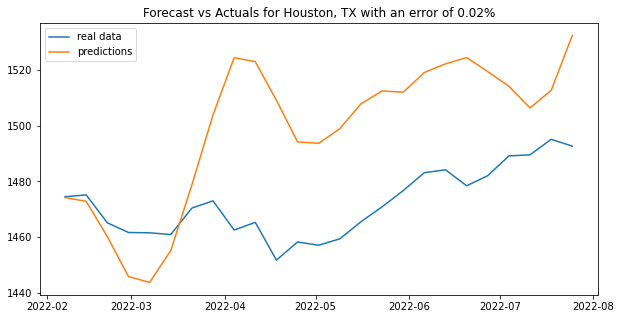

15:44:23 - cmdstanpy - INFO - Chain [1] start processing
15:44:23 - cmdstanpy - INFO - Chain [1] done processing


Jacksonville, FL


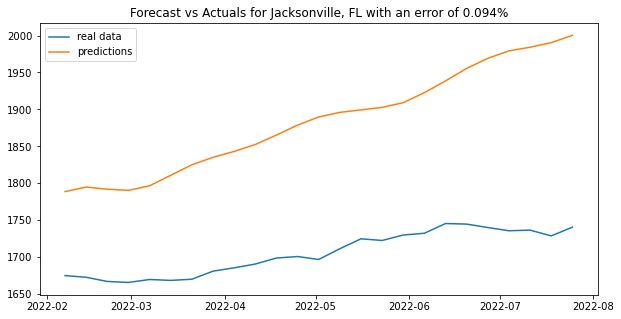

15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing


Las Vegas, NV


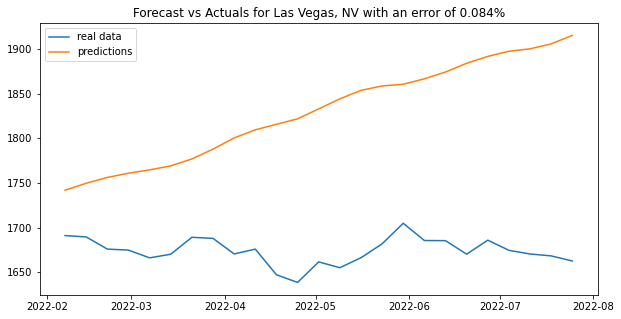

15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] done processing


Los Angeles, CA


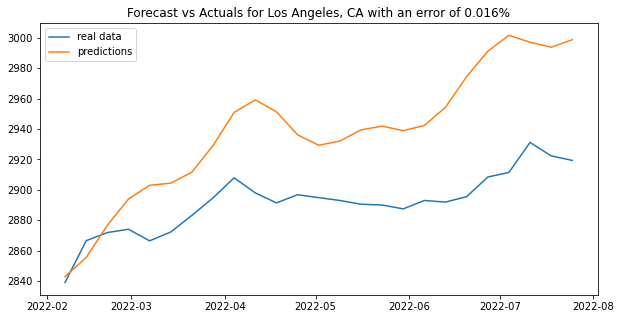

15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing


Miami, FL


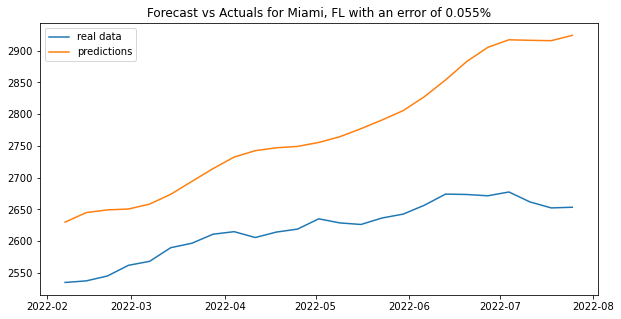

15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] done processing


Nashville, TN


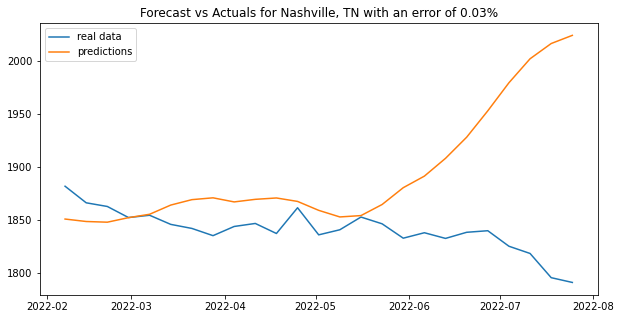

15:44:29 - cmdstanpy - INFO - Chain [1] start processing
15:44:29 - cmdstanpy - INFO - Chain [1] done processing


New York, NY


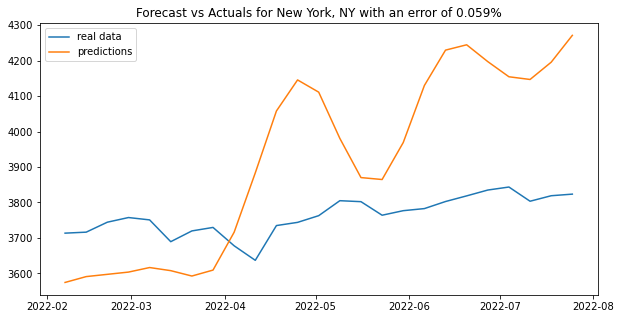

15:44:30 - cmdstanpy - INFO - Chain [1] start processing
15:44:30 - cmdstanpy - INFO - Chain [1] done processing


Orlando, FL


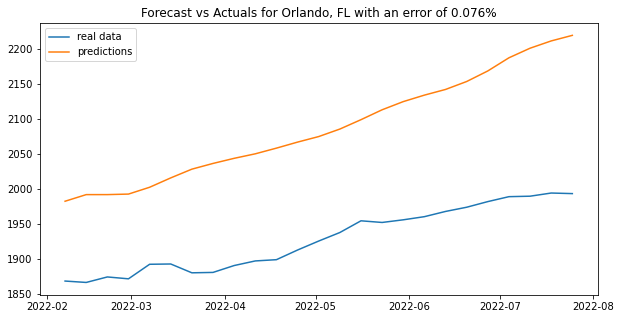

15:44:31 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] done processing


Phoenix, AZ


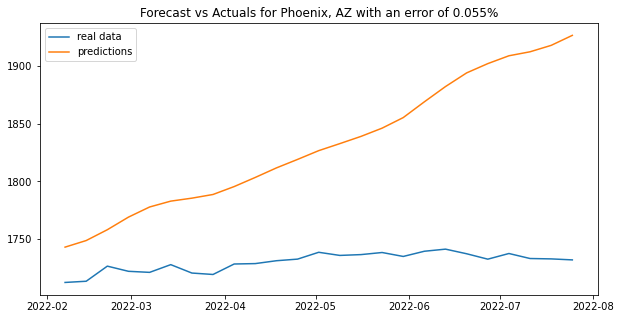

15:44:33 - cmdstanpy - INFO - Chain [1] start processing
15:44:33 - cmdstanpy - INFO - Chain [1] done processing


Portland, OR


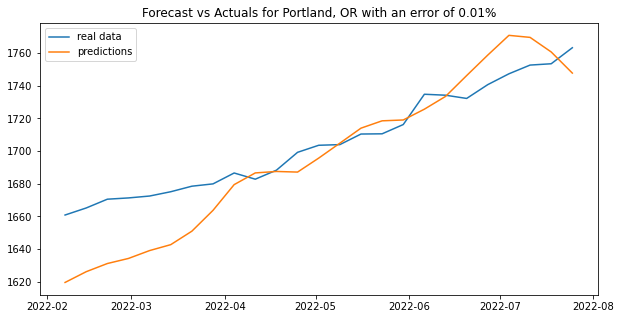

15:44:34 - cmdstanpy - INFO - Chain [1] start processing
15:44:34 - cmdstanpy - INFO - Chain [1] done processing


Raleigh, NC


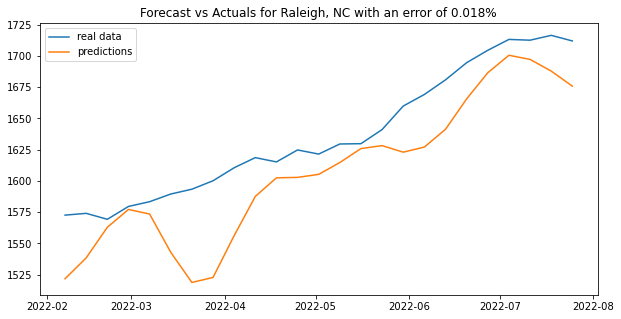

15:44:35 - cmdstanpy - INFO - Chain [1] start processing
15:44:35 - cmdstanpy - INFO - Chain [1] done processing


Riverside, CA


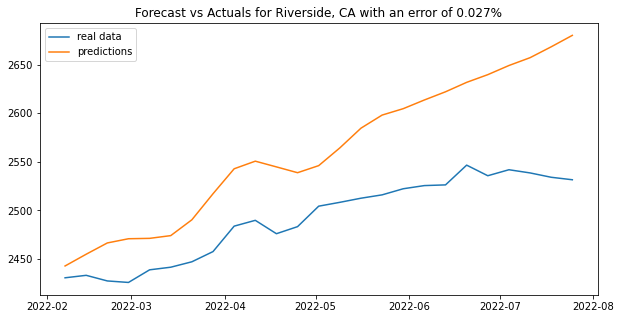

15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing


San Antonio, TX


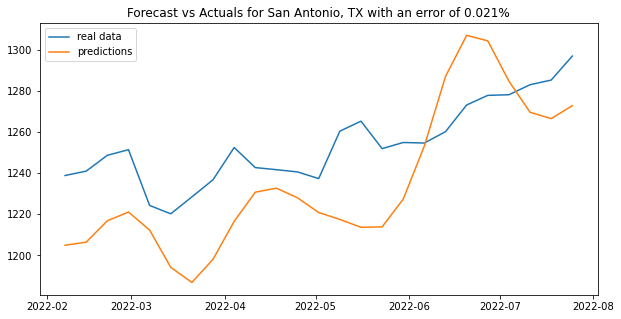

15:44:37 - cmdstanpy - INFO - Chain [1] start processing
15:44:37 - cmdstanpy - INFO - Chain [1] done processing


San Diego, CA


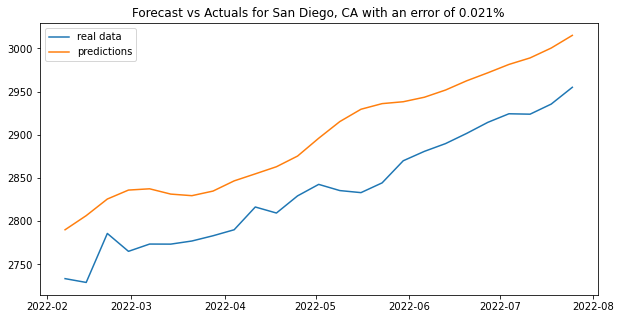

15:44:39 - cmdstanpy - INFO - Chain [1] start processing
15:44:39 - cmdstanpy - INFO - Chain [1] done processing


San Francisco, CA


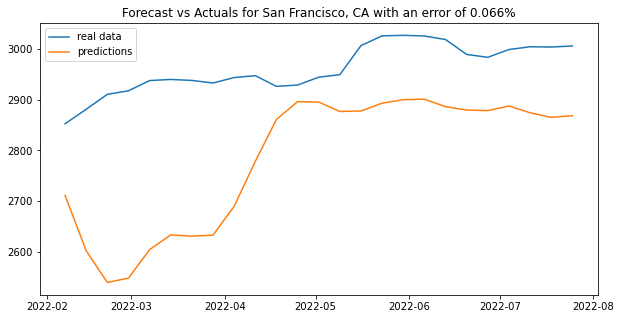

15:44:40 - cmdstanpy - INFO - Chain [1] start processing
15:44:40 - cmdstanpy - INFO - Chain [1] done processing


San Jose, CA


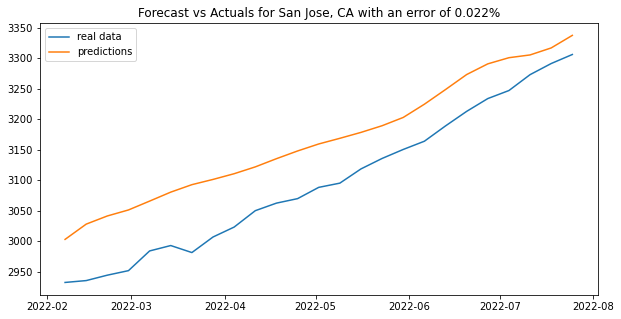

15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] done processing


Seattle, WA


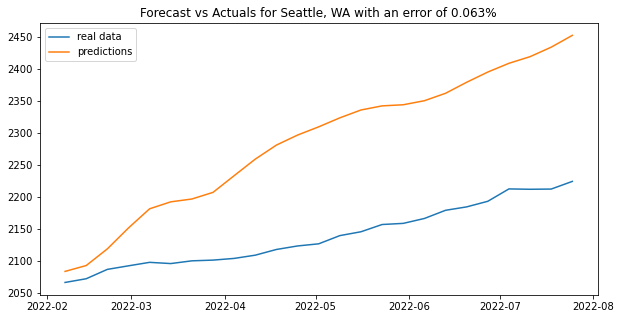

15:44:42 - cmdstanpy - INFO - Chain [1] start processing
15:44:42 - cmdstanpy - INFO - Chain [1] done processing


Tampa, FL


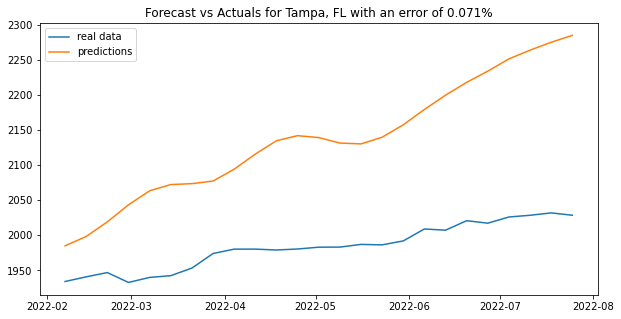

15:44:43 - cmdstanpy - INFO - Chain [1] start processing
15:44:43 - cmdstanpy - INFO - Chain [1] done processing


Washington, DC


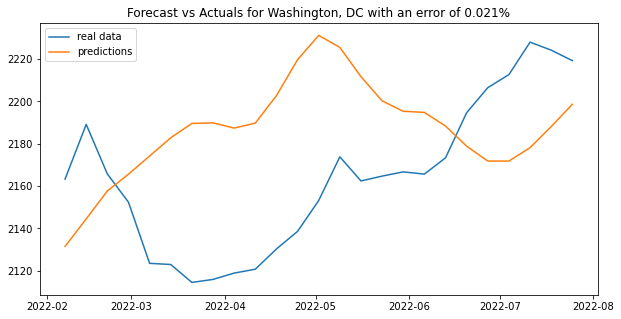

In [17]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Prophet Model'

        results = prophet_model(algorithm_name, prediction_period)
        print(unique_val)

        df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER_T4', 'VALUE')        
        #print(df_train)
        results.fit_model(df_train, 'VALUE')
        predictions = results.predict(df_test)
        results.evaluation(df_test, predictions)
        results.plot(df_test, predictions, unique_val)

**Extracting the data into a df**

In [29]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in new_df.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER').reset_index()

In [30]:
column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

df_prophet = pd.DataFrame(columns = column_names)
df_prophet

,Model,Time,MSA,Actuals,Predictions,MAPE score


In [31]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

        df = pd.DataFrame(columns = column_names)
        df

        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Prophet Model'

        results = prophet_model(algorithm_name, prediction_period)
        df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER_T4', 'VALUE')        
        results.fit_model(df_train, 'VALUE')
        predictions = results.predict(df_test)
        mape_score = results.evaluation(df_test, predictions)
        
        
        df['Actuals'] =  df_test['y']
        df['Predictions'] =  list(predictions['yhat'])
        df['MAPE score'] =  mape_score
        df['Time'] =  df_test['ds']
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val

        
        #results.evaluation(df_test, predictions)
        df_prophet = df_prophet.append(df, ignore_index=True)

15:54:23 - cmdstanpy - INFO - Chain [1] start processing
15:54:23 - cmdstanpy - INFO - Chain [1] done processing
15:54:27 - cmdstanpy - INFO - Chain [1] start processing
15:54:27 - cmdstanpy - INFO - Chain [1] done processing
15:54:32 - cmdstanpy - INFO - Chain [1] start processing
15:54:32 - cmdstanpy - INFO - Chain [1] done processing
15:54:36 - cmdstanpy - INFO - Chain [1] start processing
15:54:36 - cmdstanpy - INFO - Chain [1] done processing
15:54:41 - cmdstanpy - INFO - Chain [1] start processing
15:54:41 - cmdstanpy - INFO - Chain [1] done processing
15:54:45 - cmdstanpy - INFO - Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing
15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:50 - cmdstanpy - INFO - Chain [1] done processing
15:54:54 - cmdstanpy - INFO - Chain [1] start processing
15:54:54 - cmdstanpy - INFO - Chain [1] done processing
15:54:58 - cmdstanpy - INFO - Chain [1] start processing
15:54:59 - cmdstanpy - INFO - Chain [1]

In [32]:
.to_csv("df_prophet_msa_level_with_employment.csv")

In [33]:
df_prophet.head()

,Model,Time,MSA,Actuals,Predictions,MAPE score
0,Prophet Model,2022-02-07,"Atlanta, GA",1808.984105,1771.894101,0.034133
1,Prophet Model,2022-02-14,"Atlanta, GA",1822.501410,1805.751516,0.034133
2,Prophet Model,2022-02-21,"Atlanta, GA",1817.138120,1814.848531,0.034133
3,Prophet Model,2022-02-28,"Atlanta, GA",1810.117232,1789.296468,0.034133
4,Prophet Model,2022-03-07,"Atlanta, GA",1810.411329,1756.877960,0.034133


In [34]:
mape_scores = []


subsets = dict((x, y) for x, y in df_prophet.groupby(['MSA']))

for unique_val, subset in subsets.items():
    print(unique_val)
    mape = mean_absolute_percentage_error(subset['Actuals'], subset['Predictions'])
    print(mape)
    mape_scores.append(mape)

Atlanta, GA
0.035831855670537906
Austin, TX
0.021159336575744835
Baltimore, MD
0.12621757360932478
Boston, MA
0.008465161080569817
Charleston, SC
0.02939381539569308
Charlotte, NC
0.039387533904726775
Chicago, IL
0.027647502265662215
Dallas, TX
0.06973984429114345
Denver, CO
0.016604870025303038
Houston, TX
0.020441522627092524
Jacksonville, FL
0.10469697029828023
Las Vegas, NV
0.09305867616420838
Los Angeles, CA
0.016283443809127815
Miami, FL
0.05827689372523524
Nashville, TN
0.031951123564615665
New York, NY
0.06320662946282235
Orlando, FL
0.08213282703672715
Phoenix, AZ
0.05856145977521665
Portland, OR
0.009891210758348711
Raleigh, NC
0.017901622262137526
Riverside, CA
0.027853669368756207
San Antonio, TX
0.02061874136053762
San Diego, CA
0.021801831013505874
San Francisco, CA
0.06019571797061122
San Jose, CA
0.022690394275977462
Seattle, WA
0.06816710367127302
Tampa, FL
0.07714325153214743
Washington, DC
0.021053791633501115


In [35]:
import numpy as np
np.mean(mape_scores)

0.04465622761174387